## 简答题
1. 如果训练集有100万个实例，训练决策树（无约束）大致的深度是多少？
log2(1*10^6) = 20
2. 通常来说，子节点的基尼杂质是高于还是低于其父节点？是通常更高/更低？还是永远更高/更低？
通常是更小的，但是在某个结点处可能已经接近完美分类，但是存在噪声，但是此时再分下去可能在一侧的基尼杂质上升
3. 如果决策树过拟合训练集，减少max_depth是否为一个好主意？
是，决策树的在不限制层高的情况下特性会无限延伸，完美拟合每一个训练集上的样本，很容易过拟合，限制层高可能在高度过拟合之前停止，来降低过拟合程度
4. 如果决策树对训练集欠拟合，尝试缩放输入特征是否为一个好主意？
不是，决策树本身对于数据的大小是不敏感的，他本是只是选择某一个特征通过阈值进行拆分
5. 如果在给定的训练集上训练决策树需要一个小时，那么如果将特征数量变为两倍，训练大约需要多少时间？
原来的2倍
6. 如果在包含100万个实例的训练集上训练决策树需要一个小时，那么在包含1000万个实例的训练集上训练决策树，大概需要多长时间？提示：考虑CART算法的计算复杂度。
大约10倍

## 编程题

1. 为 新月形 数据集训练并微调一棵决策树。

a. 使用make_moons(n_samples=10000，noise=0.4)生成一个 新月形 数据集。

b. 使用train_test_split()拆分训练集和测试集。

c. 使用交叉验证的网格搜索（在GridSearchCV类的帮助下）为Decision-TreeClassifier找到适合的超参数值。提示：尝试max_leaf_nodes的多种值。

d. 使用超参数对整个训练集进行训练，并测量模型在测试集上的性能。你应该得到约85%～87%的准确率。

In [3]:
# 1. 数据生成
from sklearn.datasets import make_moons

data_moons,data_moons_target = make_moons(n_samples = 10000 , noise = .4 ,random_state= 42)


In [171]:
# 2.区分训练测试集
from sklearn.model_selection import train_test_split
X_train , X_test, y_train,y_test = train_test_split(data_moons,data_moons_target , test_size = .2 , random_state = 42,stratify = data_moons_target)


In [266]:
# 网格超参数：max_depth最大深度， max_leaf_nodes最多叶节点，min_samples_leaf叶节点不能少于的样本数 ， min_samples_split叶节点往下划分的最小样本数
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
param_grid = {
    "max_depth" : [5,6,7,8,9,10],
    "min_samples_split" : [2, 5,8,10, ],
    'max_leaf_nodes':list(range(2, 100)),
    # 'min_samples_leaf':[3, 5, 8,10 ,15],
    'random_state':[42],
    "max_features":['sqrt']

}
# DecisionTreeClassifier()
grid_search = GridSearchCV(DecisionTreeClassifier(),param_grid=param_grid,cv=3,scoring='accuracy',n_jobs=-1)

In [267]:
grid_search.fit(X_train,y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 6, 7, 8, 9, 10],
                         'max_features': ['sqrt'],
                         'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                            13, 14, 15, 16, 17, 18, 19, 20, 21,
                                            22, 23, 24, 25, 26, 27, 28, 29, 30,
                                            31, ...],
                         'min_samples_split': [2, 5, 8, 10],
                         'random_state': [42]},
             scoring='accuracy')

In [268]:
from sklearn.metrics import accuracy_score
y_pred = grid_search.best_estimator_.predict(X_test)
accuracy = accuracy_score(y_test,y_pred)
print(accuracy)

0.8585


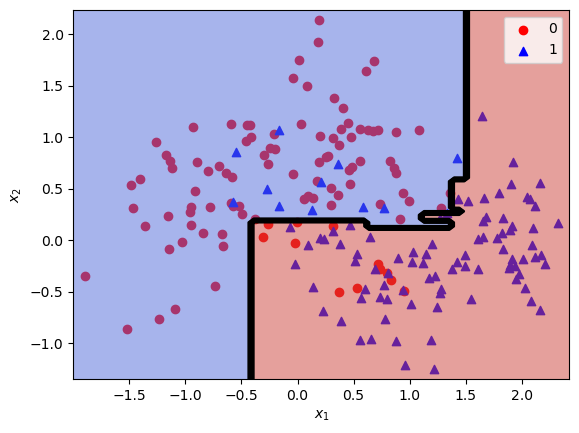

In [269]:
# 可视化：将测试集的数据(选200个，以免测试集2000个点在图上成一坨)，与决策边界绘到一张图上
import numpy as np
from matplotlib import pyplot as plt
def plot_boundary(clf,X,y,axes,alpha = .8):
    # 生成测试集前200个点
    plt.scatter(X[y==0,0],X[y==0,1],color='r',marker='o',label='0' )
    plt.scatter(X[y==1,0],X[y==1,1],color='b',marker='^',label='1')

    # 将图像网格化
    xx,yy = np.meshgrid(np.linspace(axes[0],axes[1],100),np.linspace(axes[2],axes[3],100))
    z = clf.predict(np.c_[xx.ravel(),yy.ravel()]).reshape(xx.shape)

    # 画出等高线
    plt.contourf(xx, yy, z, alpha=alpha, cmap=plt.cm.coolwarm , )
    plt.contour(xx, yy, z, linewidths=2, colors='black')

    plt.legend()
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')

    plt.axis(axes)
    plt.show()

X_plot, y_plot = X_test[:200] , y_test[:200]
plot_boundary(grid_search.best_estimator_ , X_plot,y_plot,[X_plot.min(axis=0)[0]-0.1,X_plot.max(axis=0)[0]+0.1,X_plot.min(axis=0)[1]-0.1,X_plot.max(axis=0)[1]+0.1] , alpha=.5)

2. 按照以下步骤种植森林。

a.继续之前的练习，生产1000个训练集子集，每个子集包含随机挑选的100个实例。提示：使用Scikit-Learn的ShuffleSplit类来实现。

b.使用前面得到的最佳超参数值，在每个子集上训练一棵决策树。在测试集上评估这1000棵决策树。因为训练集更小，所以这些决策树的表现可能比第一棵决策树要差一些，只能达到约80%的精度。

c.见证奇迹的时刻到了。用每个测试集实例，生成1000棵决策树的预测，然后仅保留次数最频繁的预测［可以使用SciPy的mode()函数］。这样你在测试集上可获得大多数投票的预测结果。

d.评估测试集上的这些预测，你得到的准确率应该比第一个模型更高（高出0.5%～1.5%）。恭喜，你已经训练出了一个随机森林分类器！

In [270]:
from sklearn.model_selection import ShuffleSplit
shufflesplit = ShuffleSplit(n_splits=1000,train_size=100,random_state=42)
set_ = shufflesplit.split(X_train,y_train)

In [271]:
# 生成最佳的树
best_params = grid_search.best_params_
best_estimator = DecisionTreeClassifier(**best_params)

In [272]:
from sklearn.base import clone
trees = []              # 保存每一个树的模型
tree_accuracies = []    # 保存每个树的分数
for idx,_ in set_:
    X_subset = X_train[idx]
    y_subset = y_train[idx]

    tree = clone(best_estimator)
    tree.fit(X_subset,y_subset)
    trees.append(tree)

    y_pred_ = tree.predict(X_test)
    accuracy_ = accuracy_score(y_test,y_pred_)
    tree_accuracies.append(accuracy_)


In [273]:
# trees
np.mean(tree_accuracies) # 都只有0.78左右

0.8036935000000001

In [274]:
# todo:定义一个tree_predict 进行预测
from scipy.stats import mode
def tree_predict(trees , X,y=None):
    predictions = np.zeros((len(X), len(trees)))
    for i, tree in enumerate(trees):
        predictions[:, i] = tree.predict(X)

    majority_votes, _ = mode(predictions, axis=1)
    return majority_votes.flatten()


In [275]:
y_pred = tree_predict(trees , X_test)

In [276]:
accuracy_score(y_test,y_pred)
# y_pred.shape

0.865

In [277]:
grid_search.best_params_

{'max_depth': 7,
 'max_features': 'sqrt',
 'max_leaf_nodes': 33,
 'min_samples_split': 8,
 'random_state': 42}